# Which streaming platform is the best for me?

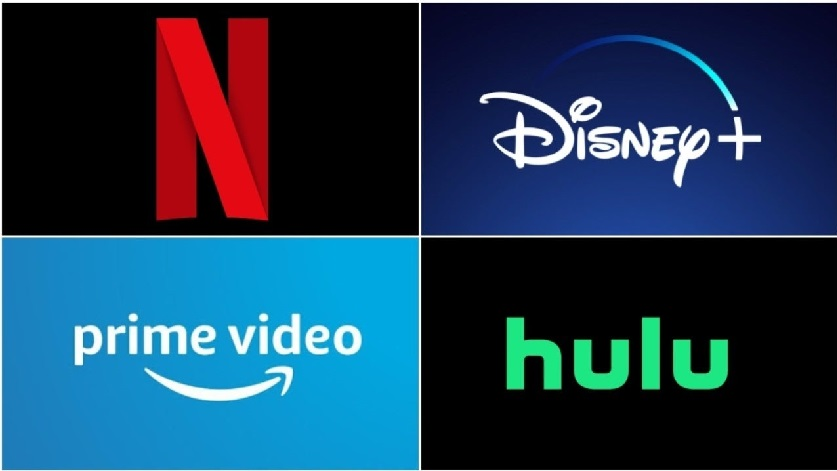

In recent years the number of online streaming platforms available has increased a lot!

Netflix, Disney+, Prime Video, hulu... what if I don't want to pay for all of them at the same time? How can I choose which service is best for me? Let's try to answer these questions.

These datasets are an amalgamation of:
*   data that was scraped, which comprised a comprehensive list of movies available on the four streaming platforms mentioned above.
* IMDb dataset

### Setting up the environment

In [ ]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
print("Setup Complete")

In [ ]:
#Importing the datasets
data1 = "../input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv"
data2 = "../input/tv-shows-on-netflix-prime-video-hulu-and-disney/tv_shows.csv"


mv_data = pd.read_csv(data1, index_col = 0)
tvshows_data = pd.read_csv(data2, index_col = 0)

# Data Preparation & Cleaning

Before starting to work with the data let's take a look on how the data is distributed among the columns and correct any mistakes we find. Some empty values may also need to be replaced so it does not affect our visualizations negatively. 

In [ ]:
#Visualizing our data
mv_data

In [ ]:
tvshows_data

Concatenating the Movies with the TV Shows dataframe:

In [ ]:
movies_data = pd.concat([mv_data, tvshows_data])

movies_data

In [ ]:
#Checking the data types for each column. Everything looks good:
movies_data.dtypes

In [ ]:
#counting the number of cells with empty values in every column
pd.isnull(movies_data).sum()

### Age

Since more than 60% of the movies don`t have data for Age in the dataset, we will replace the NaN values with 'Unknown':

In [ ]:
movies_data.Age = movies_data.Age.fillna('Unknown')

In [ ]:
#After this correction we only have numeric values on the Age column
movies_data.Age.value_counts()

### IMDb and Rotten Tomatoes columns

We will also replacing empty values for the IMDb column. Rotten Tomatoes has pecentage signs on the data. We will strip it and convert the values 
to float for performing numerical calculations:



In [ ]:
#filling NaN values with 0
movies_data.IMDb = movies_data.IMDb.fillna(0)


#stripping the % sign and converting to float
movies_data['Rotten Tomatoes'] = movies_data['Rotten Tomatoes'].str.rstrip('%').astype('float')
#Filling NaN values with 0
movies_data['Rotten Tomatoes'] = movies_data['Rotten Tomatoes'].fillna(0)

Using the describe method to check the min/max values for all numeric columns and see if there is anything wrong.

In [ ]:
movies_data.describe()

There seems to be a movie with a Runtime of 1256. Let's confirm if any mistakes have hapenned with this column:

In [ ]:
#Checking if there are movies with more than 300 minutes of runtime
movies_data[movies_data.Runtime > 300]

There really are some mistakes in the data. For example, "Colorado" shows as having 57 minutes of runtime in IMDb catalog, 
and "Law of the Lawless" has  87 minutes. Since it is more common to have movies that are three hours long (around 200min) and there are
only 7 entries above 300min I will correct these fields manually using the data available at www.imdb.com:

In [ ]:
movies_data.loc[movies_data.Title == 'Law of the Lawless', ['Runtime']] = 87
movies_data.loc[movies_data.Title == 'Scarlett', ['Runtime']] = 92
movies_data.loc[movies_data.Title == 'Carlos el terrorista', ['Runtime']] = 97
movies_data.loc[movies_data.Title == 'Colorado', ['Runtime']] = 57
movies_data.loc[movies_data.Title == 'The Inner Circle', ['Runtime']] = 96

Note: Custer's Last Stand and The Vatican Museums didn't need to be corrected. These two are really long! 

Describing the data again. Everything looks fine now:

In [ ]:
movies_data.describe()

### Language

One last change: since we are interested in working with the Language column, let's also replace the Nan values with "Unknown"

In [ ]:
movies_data.Language = movies_data.Language.fillna('Unknown')

Now there are no longer empty values in the columns Age, IMDb and Language. We are good to go.

In [ ]:

pd.isnull(movies_data).sum()

# Exploratory Analysis and Visualization

Before we ask questions about the dataset, it would help to explore these columns and better understand how representative the dataset is of the worldwide movie data. This will help us finding any patterns os biases.

### Which languages are mostly represented in the streaming service of our dataset?

In [ ]:
#counting and assigning the 20 top values to a variable
languages = movies_data.Language.value_counts().head(20)

plt.figure(figsize=(12,8))
plt.title('Top Movie Languages on Streaming Services')
sns.barplot(x=languages.values, y=languages.index)

Clearly, the number of asian and other oriental languages is very misrepresented. It is important to consider this as Netflix, Prime Video, Hulu and Disney+ are all american services. One main reason for this could be that oriental countries also make use of different streaming services not popular in America. 

Languages from eastern europe are also not present. We can ssume this data would mostly assist us in drawing conclusions related to the movies created in the America's region and western Europe. However, it is also important to mention that our dataset does not include details about who is watching these movies, which surely would include users from all over the world.  

### Does the catalogs include many old movies?

Let's see which years are represented and plot a count of movies released on every one into a histogram.

In [ ]:
movies_data.Year.unique()

In [ ]:
#plotting the Year column data into a Seaborn histogram
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.histplot(movies_data.Year,kde=False);

As expected, the vast majority of the movies are from the last 20 years. However, it is also interesting to see that there is a significant amount of old movies in the catalogs too!

### Is there a specific genre that is more present?

Let's define a helper function that turns the Genres column containing lists of values separated by commas into a data frame with one column for each possible option:

In [ ]:
#creating helper function that receives a column and returns a new dataframe 
#containing bolean values for each possible option 

def split_multicolumn(genres):
    result_df = genres.to_frame()
    options = []
    # Iterate over the column
    for idx, value  in genres[genres.notnull()].iteritems():
        # Break each value into list of options
        for option in value.split(','):
            # Add the option as a column to result
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False
            # Mark the value in the option column as True
            result_df.at[idx, option] = True
    return result_df[options]

In [ ]:
#creating a new dataframe with the splitmulticolumn function
genres_df = split_multicolumn(movies_data.Genres)

#performing a sum operation of all True values
movie_genres = genres_df.sum().sort_values(ascending=False)

In [ ]:
#plotting into a bar plot
plt.figure(figsize=(12,8))
sns.barplot(x=movie_genres.values, y=movie_genres.index);

Drama, comedy and thriller are by far the most common genres! Action is also amongst the top ones, which is expected. Later on we will try to find if there is a good difference between the genres available on each catalog.

# Asking and Answering Questions

We've already gained several insights about the available movies exploring individual columns of the dataset. Let's ask some specific questions in order to get more useful insights from this data. 

Let's obtain the following details:

1. Biggest number of movies and tv shows
2. More recent movies and tv shows
3. Most popular movie genres in each catalog
4. Better suited for for children or adults
5. The best for old movies and tv shows
6. Best IMDb / Rotten Tomatoes ratings

Before we start answering these questions, we will create individual dataframes for each platform:

In [ ]:
#Creating different dataframes for each platform
Hulu_df = movies_data.loc[(movies_data['Hulu'] > 0) ]
Disney_df = movies_data.loc[(movies_data['Disney+'] > 0) ]
PrimeVideo_df = movies_data.loc[(movies_data['Prime Video'] > 0)  ]
Netflix_df = movies_data.loc[(movies_data['Netflix'] > 0)  ]

## 1. Biggest number of movies and tv shows

In [ ]:
#Selecting the specific columns from the Dataset and saving into a new dataframe
chosen_columns = ['Netflix', 'Hulu', 'Prime Video', 'Disney+']
platforms_df = movies_data[chosen_columns]

#Counting all values for each platform
platforms = platforms_df.sum()

#Plotting into a bar plot using Seaborn

plt.figure(figsize=(12,8))
plt.title('Available Movies and TV Shows')

sns.barplot(x=platforms.index, y=platforms.values);

Prime Video is by far the service with more movie titles, followed by Netflix (who has approximatelly 1/4 of Prime Video's movies quantity). Netflix, Hulu and Disney+ together still don't reach half the quantity of movies available on Prime Video. But is this big difference also reflected on the quality of the movies?

## 2. More recent movies and tv shows

Let's filter down only movies/series dating from the last decade (> 2010).

In [ ]:
#filtering movies dating from 2010 beyond 
recent_movies_df = movies_data.loc[movies_data.Year > 2010]

#calculating the totals for each column
recent_movies = recent_movies_df[chosen_columns].sum()

#ploting into a barplot using seaborn
plt.figure(figsize=(12,8))
plt.title('NMovies and TV Shows From Last Decade')
sns.barplot(x=recent_movies.values, y=recent_movies.index)
plt.show()

The number of recent movies follows the same pattern of the previous graph - the services with more titles are also the ones with more recent titles, with Prime Video in first place by far. However, the difference between Prime Video and Netflix has decreased a lot compared to the first graph. 

Let's see the percentages below:

In [ ]:
recent_movies_percentage = (recent_movies * 100) / platforms

recent_movies_percentage

## 3. What are the most popular movie genres in each catalog?

It is clear the number of available movies is very different between platforms. But is there also a difference with the movies genres? For example, one person may (or not) be interested in documentaries or dramas. That could directly affect his choice. Let's count and visualize the number of movies available for each genre on these platforms.

In [ ]:
#Joining each platform's dataframe with genres_df
hulu_genres_df = Hulu_df.join(genres_df)
netflix_genres_df = Netflix_df.join(genres_df)
primevideo_genres_df = PrimeVideo_df.join(genres_df)
disney_genres_df = Disney_df.join(genres_df)

#creating a python list with the names of columns we want to select
chosen_columns = ['Action', 'Adventure', 'Sci-Fi',
       'Thriller', 'Comedy', 'Western', 'Animation', 'Family', 'Biography',
       'Drama', 'Music', 'War', 'Crime', 'Fantasy', 'Romance', 'History',
       'Mystery', 'Horror', 'Sport', 'Documentary', 'Musical', 'News', 'Short',
       'Reality-TV', 'Talk-Show', 'Game-Show', 'Film-Noir']

#selecting the chosen columns on each dataframe
hulu_genres = hulu_genres_df[chosen_columns]
netflix_genres = netflix_genres_df[chosen_columns]
primevideo_genres = primevideo_genres_df[chosen_columns]
disney_genres = disney_genres_df[chosen_columns]

#since each dataframe above contains only boolean values, now we can use sum() to find
#the quantities for each platform and save it into a new variable we will use in our barplot:
hulu_genres_list = hulu_genres.sum().sort_values(ascending=False).head(10)
netflix_genres_list = netflix_genres.sum().sort_values(ascending=False).head(10)
primevideo_genres_list = primevideo_genres.sum().sort_values(ascending=False).head(10)
disney_genres_list = disney_genres.sum().sort_values(ascending=False).head(10)

In [ ]:
#creating subplots to show each data into a different ax
fix, axes = plt.subplots(2,2, figsize=(20, 20))

#setting titles
axes[0,0].set_title('Hulu')
axes[0,1].set_title('Netflix')
axes[1,0].set_title('Prime Video')
axes[1,1].set_title('Disney+')

#plotting the four barplots using seaborn
sns.barplot(y=hulu_genres_list.index, x=hulu_genres_list.values, ax=axes[0,0],palette='Greens_r')
sns.barplot(y=netflix_genres_list.index, x=netflix_genres_list.values, ax=axes[0,1], palette='OrRd_r')
sns.barplot(y=primevideo_genres_list.index, x=primevideo_genres_list.values, ax=axes[1,0], palette='Blues_r')
sns.barplot(y=disney_genres_list.index, x=disney_genres_list.values, ax=axes[1,1], palette='autumn_r')
plt.show()

Hulu, Netflix and PrimeVideo have very similar quantities for the top genres, with Drama, Comedy and Thriller being the top three. Romance, Action and Documentary comes right below with small differences between each platform. 

The notable difference here is definitely Disney+. The Family genre does not even show up on the top ten list for PrimeVideo, and it is on the 9th position for both Netflix and Hulu. In contrast, Family is number one in the Disney+ catalog. A similar thing happens with other genres like Adventure, Fantasy, Animation and Musical - those genres are more predominant on the Disney+ catalog. It is important to remember, though, that the quantity of movies (x) is much higher in Prime Video and Netflix. However, as we will discuss on question 6, having a bigger catalog may also reduce the overall quality of movies offered under the mentioned genres. 

## 4. Better suited for for children or adults

Another important factor to consider is the age classification. Are you interested is movies created for Adults? Or do you have a big family with children using the service? Let's compare the age classification for each platform to see if we can find any interesting patterns.

In [ ]:
#Counting the number of values for each age classification
#We will be ignoring the movies with an 'Uknown' value in the Age column so it does not affect our graph
hulu_ages = Hulu_df.Age.value_counts().drop('Unknown')

netflix_ages = Netflix_df.Age.value_counts().drop('Unknown')

primevideo_ages = PrimeVideo_df.Age.value_counts().drop('Unknown')

disney_ages = Disney_df.Age.value_counts().drop('Unknown')

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))

#setting titles
axes[0,0].set_title('Hulu')
axes[0,1].set_title('Netflix')
axes[1,0].set_title('Prime Video')
axes[1,1].set_title('Disney+')

#plotting the four barplots using seaborn
sns.barplot(x=hulu_ages.values, y=hulu_ages.index, ax=axes[0,0],palette='Greens_r')
sns.barplot(x=netflix_ages.values, y=netflix_ages.index, ax=axes[0,1], palette='OrRd_r')
sns.barplot(x=primevideo_ages.values, y=primevideo_ages.index, ax=axes[1,0], palette='Blues_r')
sns.barplot(x=disney_ages.values, y=disney_ages.index, ax=axes[1,1], palette='autumn_r')

plt.show()

Similarly to what happened with the movie genres, the count of Age classifications follows a very similar standard for Hulu, Netflix and Prime Video. Adult movies (18+) are the biggest part of their catalogs, although they also offer a good quantity of movies for children and teenagers. Disney+, however, focuses primarily on movies for the whole family and children. It is safe to say that more than 90% of its catalog can be watched by children. 

## 5. The best for old movies and tv shows

Let's say you are interested in watching old stuff. Is there a platform better suited for that? In the cells below we will count the number of movies/shows released before 1980 on each platform. 

In [ ]:
#filtering movies released  before 1980  
old_movies_df = movies_data.loc[movies_data.Year < 1980]

#selecting only the needed columns from the dataframe
chosen_columns = ['Hulu', 'Netflix', 'Prime Video', 'Disney+']

#calculating the totals for each column
old_movies = old_movies_df[chosen_columns].sum()

#ploting into a barplot using seaborn
plt.figure(figsize=(10,6))
plt.title('Number Of Old Movies Available (<1980)')
sns.barplot(x=old_movies.values, y=old_movies.index)
plt.xticks(np.arange(0,2500,250))
plt.show()

Prime Video has really focused on the classics! That helps to explains why it has such a huge catalog when compared to the other services. More than 2K of its movies and series date prior to 1980.

## 6. Best IMDb / Rotten Tomatoes ratings

Since Prime video has a huge difference of available movies when compared with other platforms, just comparing the quantities may not provide us with a good overview. Instead let's obtain the average IMDb ratings for each platform's movies.

In [ ]:
#Creating distinct dataframes only with the movies present on individual streaming platforms

Hulu_imdb = Hulu_df.loc[Hulu_df['IMDb'] > 0 ]
Disney_imdb = Disney_df.loc[Disney_df['IMDb'] > 0 ]
PrimeVideo_imdb = PrimeVideo_df.loc[PrimeVideo_df['IMDb'] > 0 ]
Netflix_imdb = Netflix_df.loc[Netflix_df['IMDb'] > 0 ]

#Defining plot size and title
plt.figure(figsize=(12,8))
plt.title('IMDB Ratings Per Platform')

#Plotting the information from each dataset into a KDE plot
sns.kdeplot(data=PrimeVideo_imdb['IMDb'],  legend=True)
sns.kdeplot(data=Netflix_imdb['IMDb'], color='red',  legend=True)
sns.kdeplot(data=Hulu_imdb['IMDb'], color='green',  legend=True)
sns.kdeplot(data=Disney_imdb['IMDb'], color='orange', legend=True)

#Setting the legend
plt.legend(['Prime Video', 'Netflix', 'Hulu', 'Disney+'])
plt.show()

Altough Prime Video is by far the platform with more available titles, it by far the last in the IMDb ratings comparison above. It is expected, thought, that such a huge catalog cannot be formed only by top rated movies/series. 

This explains why the area for titles between 2-5 ratings is much more bigger for Prime Video (blue) on the plot above. At the same time, Disney and Hulu both have a much higher average of good rated movies, respectively. Could this indicate that having the bigger catalog does not mean having the best one?

Let's dig a little deeper by checking the mean for each platform.

In [ ]:
#Creating a python dictionary to store the mean for each platform
Means = {}

#obtaining the mean for the IMDb column in each dataset
Means['Prime Video'] = PrimeVideo_imdb.IMDb.mean()
Means['Disney+'] = Disney_imdb.IMDb.mean()
Means['Hulu'] = Hulu_imdb.IMDb.mean()
Means['Netflix'] = Netflix_imdb.IMDb.mean()

#plotting a horizontal bar and defining figure size, title and xticks
plt.figure(figsize=(12,6))

sns.barplot(y=list(Means.keys()), x=list(Means.values()))
plt.title('Mean of IMDB Ratings per Platform')

plt.xticks([0,1,2,3,4,5,6,7,8])
plt.show()

This graph confirms our hypothesis: Prime Video has the bigger catalog, but also comes last when comparing the mean of IMDb ratings with other services. Hulu, on the other hand, has much less movies available, but the overall IMDb rating of their movies is better. Netflix and Disney+ have very similar mean ratings and come a little after Hulu.

But does this mean that the Prime Video catalog does not have the same quality? Isn't this difference too small considering that it has approximatelly 3 times more movies than the other platforms?

Let us try to clarify this be getting another insight: how many movies and tv shows with very good ratings (>= 8) are available on each service:

In [ ]:
#Creating distinct dataframes only with the movies present on individual streaming platforms
PrimeVideo_top_movies_df = PrimeVideo_df.loc[(PrimeVideo_df['IMDb'] >= 8)] 
Netflix_top_movies_df = Netflix_df.loc[(Netflix_df['IMDb'] >= 8) ]
Hulu_top_movies_df = Hulu_df.loc[(Hulu_df['IMDb'] >= 8)]
Disney_top_movies_df = Disney_df.loc[(Disney_df['IMDb'] >= 8)] 

#Defining plot size and title
plt.figure(figsize=(12,8))
plt.title('IMDB Ratings Higher Than 8')

#Plotting the information from each dataset into a histogram
sns.histplot(PrimeVideo_top_movies_df['IMDb'], kde=False)
sns.histplot(Netflix_top_movies_df['IMDb'], color='red', kde=False)
sns.histplot(Hulu_top_movies_df['IMDb'], color='green', kde=False)
sns.histplot(Disney_top_movies_df['IMDb'], color='orange', kde=False)                                       
                                      

#Setting the legend
plt.legend(['Prime Video', 'Netflix', 'Hulu', 'Disney+'])
plt.show()

This is really surprinsing! Prime Video has a catalog several times bigger than Hulu, but still loses on the quantity of well rated movies and tv shows. Netflix is also very close to it. We can conclude that the overall quality os the Hulu and Netflix catalogs are much better. Having more movies and series does not mean having the best catalog.

Do we see similar patterns on the Rotten Tomatoes ratings?

In [ ]:
#creating dataframes for the Rotten Tomatoes column exclusing all empty values
Hulu_rotten_tomatoes = Hulu_df.loc[Hulu_df['Rotten Tomatoes'] != 0 ]
Disney_rotten_tomatoes = Disney_df.loc[Disney_df['Rotten Tomatoes'] != 0 ]
PrimeVideo_rotten_tomatoes = PrimeVideo_df.loc[PrimeVideo_df['Rotten Tomatoes'] != 0 ]
Netflix_rotten_tomatoes = Netflix_df.loc[Netflix_df['Rotten Tomatoes'] != 0 ]

In [ ]:
#Defining plot size and title
plt.figure(figsize=(12,8))
plt.title('Rotten Tomatoes Ratings Per Platform')

#Plotting the information from each dataset into a KDE plot
sns.histplot(PrimeVideo_rotten_tomatoes['Rotten Tomatoes'], kde=False,  legend=True)
sns.histplot(Netflix_rotten_tomatoes['Rotten Tomatoes'], kde=False, color='red',  legend=True)
sns.histplot(Hulu_rotten_tomatoes['Rotten Tomatoes'], kde=False, color='green',  legend=True)
sns.histplot(Disney_rotten_tomatoes['Rotten Tomatoes'], kde=False, color='orange', legend=True)

#Setting the legend
plt.legend(['Prime Video', 'Netflix', 'Hulu', 'Disney+'])
plt.show()

The pattern here is bit different. Netflix comes second to Prime Video and Hulu comes third.  We can also find something interesting by getting the mean of Rotten Tomatoes ratings for each:

In [ ]:
Means_rt = {}

#obtaining the mean for the IMDb column in each dataset
Means_rt['Prime Video'] = PrimeVideo_rotten_tomatoes['Rotten Tomatoes'].mean()
Means_rt['Disney+'] = Disney_rotten_tomatoes['Rotten Tomatoes'].mean()
Means_rt['Hulu'] = Hulu_rotten_tomatoes['Rotten Tomatoes'].mean()
Means_rt['Netflix'] = Netflix_rotten_tomatoes['Rotten Tomatoes'].mean()

#plotting a horizontal bar and defining figure size, title and xticks
plt.figure(figsize=(12,6))

sns.barplot(y=list(Means_rt.keys()), x=list(Means_rt.values()))
plt.title('Mean of Rotten Tomatoes Ratings per Platform')

plt.show()

The mean is very similar for the four platforms, but again, Hulu and Netflix comes first. Hulu is the only one scoring more than 70% mean on their ratings. 

# Inferences

We've obtained some interesting inferences from this dataset. Here's a summary of them:

* **Quantity of Movies**: Prime Video is by far the service with more movies and tv shows, followed by Netflix. Netflix, Hulu and Disney+ together still don't reach half the quantity of movies available on Prime Video.
* **Recent Titles**: Prime Video is also the catalog with the biggest quantity of recent movies (10 years old or less). But this represents only 50% of its catalog. On the other hand, Netflix and Hulu have a much bigger percentage of their catalogs composed by recent movies - 82% and 67% respectively. And Disney+ has surprisingly only 36%! Which means their movie catalog is currently mostly of classics.
* **Genres**: Hulu, Netflix and PrimeVideo have very similar quantities for the top genres, with Drama, Comedy and Thriller being the top three ones. Disney+ has a different catalog, with Family, Adventure, Fantasy, Animation and Musical being the most predomintant genres. 
* **Age**: Adult movies (18+) is the biggest part of the Netflix, Prime Video and Hulu catalogs, although they also offer a good quantity of movies for children and teenagers. Disney+, focuses primarily on movies for the whole family and children. It is safe to say that more than 90% of its catalog can be watched by children.
* **Old Movies**: Prime Video has really focused on the classics! That helps to explains why it has such a huge catalog when compared to the other services. About 2K of the total catalog is from movies prior to 1980.
* **Movie Ratings**: Hulu has the best mean ratings for both IMDB and Rotten Tomatoes.  All platforms offer a good quantity of well rated movies in their catalog. However, the Prime Video ratings mean is much lower compared to the other platforms. We can conclude that the overall quality os the Hulu and Netflix catalogs are much better. Having more movies and series does not mean having the best catalog.

# Conclusions:

What can help me decide between a specific platform?

* If you are interested on having a **huge catalog** Prime Video is definitely a good choice. Netflix comes second and is also a good choice - both have a big catalog!
* For watching **recent movies and tv shows** (last decade), Netflix is a great option - those compose 81% of its catalog. Hulu also has a good percentage of 67%.
* If you are interested in movies for **Adult**s, and genres such as Dramas, Comedies and Thriller, Netflix , Hulu  and Prime Video are all good options. 
* Disney+ is defintely a great choice for **family friendly** movies and genres such as fantasy and adventure.
* Prime Video seems to be the best platform for watching very **old movies** (40 years old or more) since it offers about 2K movies prior to 1980.
* Hulu has a smaller catalog, but it comes first on the ratings mean. If you are interested in having a **small catalog with good quality stuff**, Hulu may be the best choice. Disney+ also has a small catalog while keeping a good overall quality. Its catalog should increase during the next years since it is a new service. Netflix is a good middle term between having a big catalog x quality. Prime Video comes last on ratings, a consequence of having such a huge catalog.

Please have in mind this is a beginner project, which is actually my first one on Kaggle. Any comments and suggestions are welcome!

Thanks for reading =)